In [1]:
from torchvision import transforms as tfms
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
import torch
import numpy

# For video display:
from IPython.display import HTML
from base64 import b64encode

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"


# load model

In [2]:
from utils.model_loader import load_model

config_path = './configs/v1-inference.yaml'
ckpt_path = '../stable-diffusion-webui/models/Stable-diffusion/pastelMixStylizedAnime_pastelMixFull.safetensors'

model = load_model(config_path, ckpt_path)

# Create Sampler

In [7]:
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
from modules.sampler import VanillaStableDiffusionSampler

sampler = VanillaStableDiffusionSampler(DDIMSampler, model)


# Text-to-Image 

In [24]:
from modules.prompt_parser import get_learned_conditioning, get_multicond_learned_conditioning
%load_ext autoreload
%autoreload


model.to(torch_device)
# prompt = ["A cool digital illustration of a steampunk computer laboratory with clockwork machines, 4k, detailed, trending in artstation, fantasy vivid colors"]
# prompt_negative = [""]
prompt = ["masterpiece, best quality, loli, animal ears, blue eyes, seduction, sea, wet,  cute face, long hair, white hair, 1girl, sexy,  8K, high resolution"]
prompt_negative = ["deformation, ugly, bad quality, distortion"]

height = 512
width = 512
random_seed = 626633957

num_inference_steps = 40
cfg_scale = 7.5
batch_size = 1

# Positive Text Embedding
positive_text_embeddings  = get_multicond_learned_conditioning(model, prompt, num_inference_steps)
# positive_text_embeddings = model.get_learned_conditioning(prompt)
print(f'the postive text embedding: {positive_text_embeddings.batch[0][0]}')

# Negative Text Embedding
negative_text_embeddings = get_learned_conditioning(model, prompt_negative, num_inference_steps)
# negative_text_embeddings  = model.get_learned_conditioning(prompt_negative)
print(f'the shape of negative text embedding: {negative_text_embeddings}')

# Prep latents
torch.manual_seed(random_seed)
latents = torch.randn((batch_size, 4, height // 8, width // 8), device='cpu')
latents = latents.to(torch_device)


sample_ddim = sampler.sample(steps=num_inference_steps, 
                             conditioning=positive_text_embeddings, 
                             unconditional_conditioning=negative_text_embeddings, 
                             unconditional_guidance_scale=cfg_scale, 
                             x=latents)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
the postive text embedding: schedules: [ScheduledPromptConditioning(end_at_step=40, cond=tensor([[-0.3775,  0.0151, -0.0611,  ..., -0.5000, -0.2917,  0.0669],
        [-2.3404, -0.1266,  2.0319,  ..., -0.1971,  0.6385,  2.2474],
        [-1.6982,  0.0739,  1.9154,  ..., -0.3571,  0.6333,  1.3725],
        ...,
        [-0.7804, -0.0602,  0.1772,  ...,  0.0226, -0.8555, -0.5018],
        [-0.7722, -0.0629,  0.2076,  ..., -0.0152, -0.8122, -0.4549],
        [-0.7888, -0.0335,  0.1327,  ...,  0.0816, -0.6958, -0.6974]],
       device='cuda:0'))], weight: 1.0
the shape of negative text embedding: [[ScheduledPromptConditioning(end_at_step=40, cond=tensor([[-0.3775,  0.0151, -0.0611,  ..., -0.5000, -0.2917,  0.0669],
        [ 0.6019,  0.0330,  1.2110,  ..., -1.9056, -0.0695,  0.6040],
        [ 0.2015, -0.0911,  1.7371,  ..., -0.7249,  0.5819, -0.9623],
        ...,
        [-0.7843, -0.7737,  0.9856,  .

DDIM Sampler: 100%|██████████| 40/40 [00:05<00:00,  6.73it/s]


In [5]:
print(sample_ddim.shape)

torch.Size([1, 4, 64, 64])


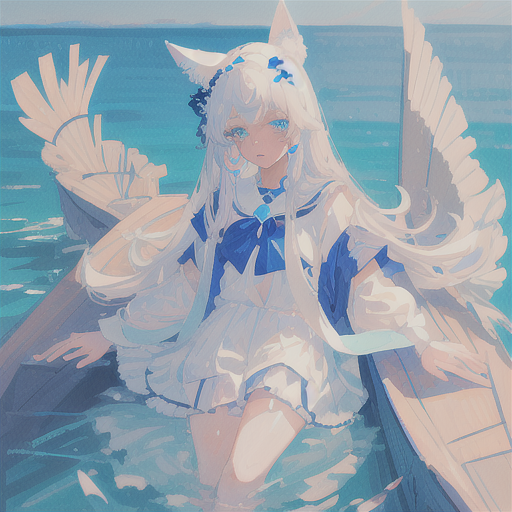

In [6]:

image = model.decode_first_stage(sample_ddim)

# Display
image = (image / 2.0 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]